In [1]:
from constants import *
from solver import SolveScheduling
from get_data import *
from train import * 
from models import *
from projectnet import *
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
params = {"n": 24, "c_ramp": 0.4, "gamma_under": 50, "gamma_over": 0.5}
scheduling_solver = SolvePointQP(params)
dist_solver = SolveScheduling(params)

X_train, Y_train, X_test, Y_test, X_train_pt, Y_train_pt, X_test_pt, Y_test_pt = get_data() 

In [3]:
G = scheduling_solver.G[24*2:24*2+23*2,:]
A = torch.cat((G, torch.eye(G.shape[0]).to(DEVICE)), dim=1).float().to(DEVICE)
b = params['c_ramp'] * torch.ones((24 - 1)*2, device=DEVICE).float()

In [4]:
mle_net = Net(X_train[:,:-1], Y_train, [200,200]).to(DEVICE)
train_mle_net(mle_net, params, X_train_pt, Y_train_pt)

epoch: 0 loss: 0.17920169979333878 times: 0.3297889232635498
epoch: 1 loss: 0.15260260853056723 times: 0.22669458389282227
epoch: 2 loss: 0.13717754070575422 times: 0.19279257456461588
epoch: 3 loss: 0.12293945744633675 times: 0.17633122205734253
epoch: 4 loss: 0.10247148722410201 times: 0.16598954200744628
epoch: 5 loss: 0.09139559432864189 times: 0.15850265820821127
epoch: 6 loss: 0.08432182785123586 times: 0.152796847479684
epoch: 7 loss: 0.07917161662131549 times: 0.14940640330314636
epoch: 8 loss: 0.07453170385211706 times: 0.14724318186442056
epoch: 9 loss: 0.07093202453106642 times: 0.1444946527481079
epoch: 10 loss: 0.06707410674542189 times: 0.14248830621892755
epoch: 11 loss: 0.06395286597311496 times: 0.14069845279057822
epoch: 12 loss: 0.06120778292417526 times: 0.1396648333622859
epoch: 13 loss: 0.05867682598531246 times: 0.1384709051677159
epoch: 14 loss: 0.05686978280544281 times: 0.1373550573984782
epoch: 15 loss: 0.05479804515838623 times: 0.13629025220870972
epoch: 16

Net(
  (lin): Linear(in_features=149, out_features=24, bias=True)
  (net): Sequential(
    (0): Linear(in_features=149, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=200, out_features=24, bias=True)
  )
)

In [7]:
rounds = 5

In [8]:
projectnet = ProjectNet(A, b, 24, rounds=rounds).to(DEVICE)
train_projectnet(projectnet, mle_net(X_train_pt).detach(), params, epochs=50, verbose=True)
torch.save(projectnet.state_dict(), "saved_models/projectnet{}.pt".format(params['c_ramp']))

epoch  0  mean loss:  4.18284008365411  median  3.9846460819244385 cur:  1.5376639366149902
epoch  1  mean loss:  2.721964291334152  median  2.080314874649048 cur:  1.2822952270507812
epoch  2  mean loss:  1.30033556163311  median  1.5520480275154114 cur:  0.6649987697601318
epoch  3  mean loss:  0.8545614406466484  median  1.2825250625610352 cur:  0.4993521571159363
epoch  4  mean loss:  0.596975120306015  median  1.0081420540809631 cur:  0.46785664558410645
epoch  5  mean loss:  0.45932706981897353  median  0.8250999748706818 cur:  0.42127329111099243
epoch  6  mean loss:  0.38493684962391855  median  0.6994702219963074 cur:  0.3650592267513275
epoch  7  mean loss:  0.3432394604384899  median  0.581022173166275 cur:  0.3170381188392639
epoch  8  mean loss:  0.3199559146165848  median  0.5299622118473053 cur:  0.31474143266677856
epoch  9  mean loss:  0.30364779233932493  median  0.47323331236839294 cur:  0.3098122179508209
epoch  10  mean loss:  0.289999230504036  median  0.437954962

In [66]:
# projectnet = ProjectNet(A, b, 24, rounds=5).to(DEVICE)
# projectnet.load_state_dict(torch.load("saved_models/projectnet{}.pt".format(params['c_ramp'])))

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/projectnet0.1.pt'

In [22]:
# projectnet.eval()
# model_pnet = Net(X_train[:,:-1], Y_train, [200,200]).to(DEVICE)
# train_with_pnet(model_pnet, projectnet, X_train_pt, Y_train_pt, params, rounds=rounds, epochs=50, lr=1e-4)

projectnet = ProjectNet(A, b, 24, rounds=rounds).to(DEVICE)
train_projectnet(projectnet, model_pnet(X_train_pt).detach(), params, epochs=50, verbose=True)
torch.save(projectnet.state_dict(), "saved_models/projectnet{}.pt".format(params['c_ramp']))

train_with_pnet(model_pnet, projectnet, X_train_pt, Y_train_pt, X_test_pt, Y_test_pt, params, rounds=rounds, epochs=50, lr=1e-4)
torch.save(model_pnet.state_dict(), "saved_models/model_pnet{}.pt".format(params['c_ramp']))

epoch  0  mean loss:  3.9755948392244487  median  3.781075954437256 cur:  1.3339604139328003
epoch  1  mean loss:  2.6845109701156615  median  2.1006016731262207 cur:  1.1829404830932617
epoch  2  mean loss:  1.4345572209358215  median  1.6450846195220947 cur:  0.7328975200653076
epoch  3  mean loss:  1.1463060581684112  median  1.4490913152694702 cur:  0.5920180082321167
epoch  4  mean loss:  0.9871708887815476  median  1.3116450309753418 cur:  0.46538084745407104
epoch  5  mean loss:  0.8187243214249611  median  1.177674412727356 cur:  0.3478233218193054
epoch  6  mean loss:  0.7040427184104919  median  1.068730354309082 cur:  0.3444867730140686
epoch  7  mean loss:  0.617328149676323  median  0.9836393892765045 cur:  0.25425514578819275
epoch  8  mean loss:  0.5436446094512939  median  0.8949326872825623 cur:  0.21643410623073578
epoch  9  mean loss:  0.5189338359236717  median  0.8517062962055206 cur:  0.2465420365333557
epoch  10  mean loss:  0.49954450339078904  median  0.7858456

In [7]:
# model_pnet = Net(X_train[:,:-1], Y_train, [200,200]).to(DEVICE)
# model_pnet.load_state_dict(torch.load("saved_models/model_pnet{}.pt".format(params['c_ramp'])))

<All keys matched successfully>

In [35]:
net_costs = []
batch_size = 100
for k in range(X_test_pt.shape[0] // batch_size):
    p = model_pnet(X_test_pt[k:k+batch_size,:]).detach()
    d = projectnet(p, rounds=5)
    cost_test = task_loss_no_mean(d, Y_test_pt[k:k+batch_size,:], params).detach().cpu().numpy()
    net_costs.append(cost_test)
    # test_costs.append(cost_test.item())

0.12967134

In [54]:
task_net = Net2(X_train[:,:-1], Y_train, [200,200]).to(DEVICE)
train_task_net(task_net, params, X_train_pt, Y_train_pt)
torch.save(task_net.state_dict(), "saved_models/task_net.pt")

epoch: 0 loss: 2.3861129613132053 times: 24.14952540397644
epoch: 1 loss: 2.1324610537095916 times: 23.861863136291504
epoch: 2 loss: 1.9182594444097503 times: 23.7902729511261
epoch: 3 loss: 1.6996734061814711 times: 24.037619590759277
epoch: 4 loss: 1.3475223767746587 times: 23.965864896774292
epoch: 5 loss: 1.0768389630970947 times: 23.944028735160828
epoch: 6 loss: 0.8743361698029382 times: 23.86519401414054
epoch: 7 loss: 0.7175933306379032 times: 23.74442908167839
epoch: 8 loss: 0.6053115277078343 times: 23.736521032121445
epoch: 9 loss: 0.5282188725486012 times: 23.688804364204408
epoch: 10 loss: 0.4696702816457084 times: 23.784093488346446
epoch: 11 loss: 0.4312673042086059 times: 23.800779183705647
epoch: 12 loss: 0.40697264646592557 times: 23.800506976934578
epoch: 13 loss: 0.3848881525097938 times: 23.80308427129473
epoch: 14 loss: 0.3756143836876597 times: 23.905430666605632
epoch: 15 loss: 0.37408408260234366 times: 23.87533275783062
epoch: 16 loss: 0.36698700728811107 tim

In [48]:
task_results = np.load("task_results.npy")
mle_results = np.load("mle_results.npy")

In [55]:
p_task, s_task = task_net(X_test_pt)
d_task = dist_solver(p_task, s_task).detach()
cost_task = task_loss_no_mean(d_task, Y_test_pt, params)

In [46]:
net_costs=np.array(net_costs).reshape(600,24)
net_costs.shape

(600, 24)

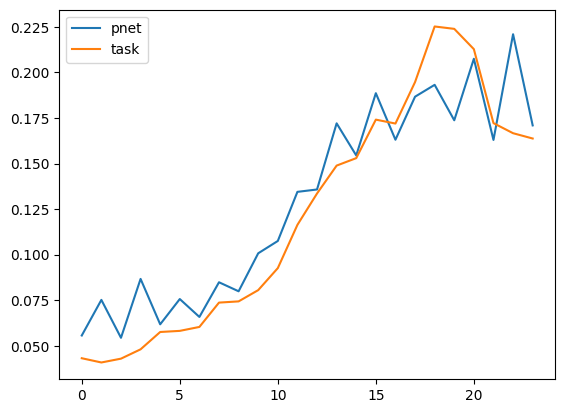

In [51]:
plt.plot(range(24), np.mean(net_costs,axis=0), label='pnet')
# plt.plot(range(24), cost_task.mean(0).cpu().numpy(), label='task')
plt.plot(range(24), task_results[:600,:].mean(0), label='task')
# plt.plot(range(24), mle_results.mean(0), label='mle')
plt.legend()
plt.show()

In [43]:
torch.max(d[:,:23] - d[:,1:])

tensor(0.1000, device='cuda:0')

In [52]:
task_results.mean()

0.13162148

In [53]:
net_costs.mean()

0.12967134